In [1]:
import time
import random
import os
import cv2
import numpy as np
import pandas as pd
import gc

from PIL import Image
from openslide import OpenSlide, OpenSlideUnsupportedFormatError

from WSIAnalysis.patch_extraction.extract_patches_split import \
openSlide_init, read_wsi, construct_colored_wsi, get_contours, \
segmentation_hsv, construct_bags, save_to_disk, parse_annotation, \
extract_all

from WSIAnalysis.patch_extraction.utils import \
calculate_intersection, calculate_polygon, calc_tumorArea

In [2]:
'''
    Global
'''
PATCH_SIZE = 500
CHANNEL = 3

THRESH = 90

PIXEL_WHITE = 255
PIXEL_TH = 200
PIXEL_BLACK = 0

SPLIT = 4

level = 1
mag_factor = pow(2, level)

### Data
Here we are using data samples from [Camelyon 2017 Grand Challenge](https://camelyon17.grand-challenge.org/) as an example.

### dirs & paths

In [5]:
training_dir='../data-wsi/camelyon17/training/'
anno_dir = '../data-wsi/camelyon17/lesion_annotations/'

'''
    For level1 WSIs, we mannully split the whole slide into 16(4*4) sections.
'''
section_list = ['00', '01', '02', '03', \
                '10', '11', '12', '13', \
                '20', '21', '22', '23', \
                '30', '31', '32', '33']

dir_prefix='./dataset_patches/' 
dir_end='/level1/patches/'

slideEnd='.tif'
annoEnd='.xml'

slide_ = 'patient_017_node_2'

### OpenSlide object initialization
level 1: 20x magnification (40x is the original setting). Here we can only load one section (1/16 of the whole image) at a time:
             _ _ _ _
            |_|_|_|_|                  
            |_|_|_|_|
            |_|_|_|_|
            |_|_|_|_| 
            
Here is an example of how we split (not the example slide below):
![splitsample](http://119.29.151.114/images/splitsample.jpg)

In [6]:
slide_path_ = training_dir + slide_ + slideEnd
anno_path_ = anno_dir + slide_ + annoEnd

patches_all = list()

In [7]:
wsi_obj=openSlide_init(slide_path_, level)
polygon_list, anno_list = parse_annotation(anno_path_, wsi_obj, level, mag_factor)

level1 size(w, h): 47484 105289
parsing annotation xml:
0
1
2
3
4
5
6
7
8
9
10
11
12


Above output indicates that in this slide, patient_017_node_2.tif, there are 13 annotated tumor areas.

### Thumbnail

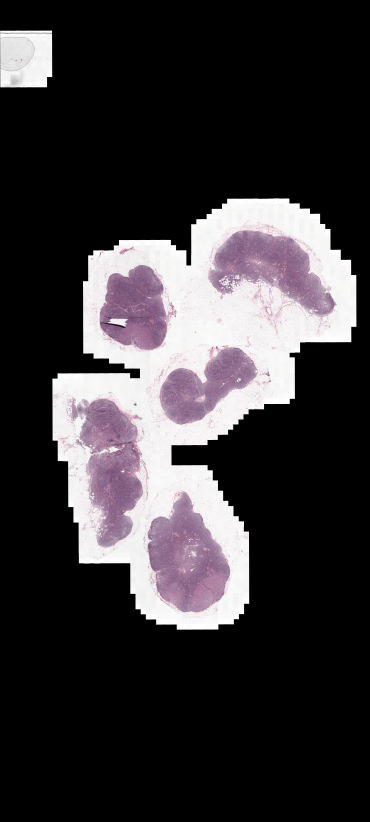

In [41]:
sample_level=8
sample_mag_factor=pow(2, sample_level)

width_sample, height_sample = wsi_obj.level_dimensions[sample_level]
rgba_image_thumbnail = wsi_obj.read_region((0,0), sample_level, \
                                           (width_sample, height_sample))

rgba_image_thumbnail

### section 12

In [10]:
sect = '12' # 21 and 12 are different

#### Load into memory

In [11]:
rgba_image = read_wsi(wsi_obj, level, mag_factor, sect)

47484 105289
11871 26322
width, height: (11871, 26322)
transformed: (26322, 11871, 4)
Time spent on loading:  28.572628259658813


The above output:<br>
47484 105289: width and height of the whole WSI;<br>
11871 26322: width and height of the '12' section;

### Change color space
Here we get **rgb, gray and hsv** version of the WSI.<br>
The returned variables are all numpy arrays.

In [12]:
wsi_rgb_, wsi_gray_, wsi_hsv_ = construct_colored_wsi(rgba_image)

In [15]:
print(type(wsi_rgb_))
print(wsi_rgb_.shape)

print(type(wsi_gray_))
print(wsi_gray_.shape)

print(type(wsi_hsv_))
print(wsi_hsv_.shape)

<class 'numpy.ndarray'>
(26322, 11871, 3)
<class 'numpy.ndarray'>
(26322, 11871)
<class 'numpy.ndarray'>
(26322, 11871, 3)


### Free up memory

In [16]:
del rgba_image
gc.collect()

107

### Segmentation¶
Here we use the hsv array to perform segmentation.<br>
And only the contours and mask will be passed to the next function to extract patches.

In [17]:
bounding_boxes, contour_coords, contours, mask \
= segmentation_hsv(wsi_hsv_, wsi_rgb_)

HSV segmentation: 
thresh shape: (26322, 11871)
Closing step: 
image_close size (26322, 11871)
Openning step: 
image_open size 312468462
Getting Contour: 
contour image:  (26322, 11871)
mask shape (26322, 11871, 3)


#### Sample of contours:
In the next step, we will extract patches from these selected regions(contours).<br>
** It should be noticed that these selected regions are not necessarily tumor areas, there are just patches that are considered not to be background areas.**

In [18]:
print("Number of contours:", len(contour_coords))
print("Contour shape: ", contour_coords[1].shape)
print(contour_coords[1])

Number of contours: 3267
Contour shape:  (8, 2)
[[11861 26185]
 [11859 26187]
 [11859 26193]
 [11860 26194]
 [11863 26194]
 [11864 26195]
 [11870 26195]
 [11870 26185]]


### Tip
It should be noticed that the contours in OpenCV usually come with one additional dimension, which is the only difference between **contour_coords** and **contours** shown below. <br><br>In most cases, the additional dimension is useless, but some of the OpenCV [drawing functions](https://docs.opencv.org/3.3.1/d4/d73/tutorial_py_contours_begin.html) require that we keep this additional shape. In that case, [np.expand_dims()](https://docs.scipy.org/doc/numpy/reference/generated/numpy.expand_dims.html) and  [np.squeeze()](https://docs.scipy.org/doc/numpy/reference/generated/numpy.squeeze.html) could be very helpful.

In [28]:
print(contour_coords[0].shape)
print(np.expand_dims(contour_coords[0], axis=1).shape)

print(contours[0].shape)
print(np.squeeze(contours[0]).shape)

(5, 2)
(5, 1, 2)
(5, 1, 2)
(5, 2)


### Extract Patches
Setting:<br>
level 1 (20x magnification)<br>
patch size: (500, 500, 3)<br>
step size: 250<br>
Select patches from the top 5 largest regions (major regions)
<br>
**!!! all the coordinates in *patch_coords* are still locations on the whole image**

In [32]:
'''
    !!! Different from the one in extract_patches.py that deals with the whole image
    at a time, the construct_bags() here takes an additional arg: sect.
    
    Also, it returns coordinates both in the global image reference and 
    local image reference.
'''

patches, patches_coords, patches_coords_local = \
construct_bags(wsi_obj, wsi_rgb_, contours, mask, \
               level, mag_factor, PATCH_SIZE, sect)

1 2
delta: 11871 52644
region 0
ROI length: 30 71
read_region (scaled coordinates):  0 0
Numpy mask shape:  (500, 500, 3)
Numpy patch shape:  (500, 500, 3)
global: 11871 52644
local:  0 0
Saved

read_region (scaled coordinates):  250 0
Numpy mask shape:  (500, 500, 3)
Numpy patch shape:  (500, 500, 3)
global: 12121 52644
local:  250 0
Saved

read_region (scaled coordinates):  500 0
Numpy mask shape:  (500, 500, 3)
Numpy patch shape:  (500, 500, 3)
global: 12371 52644
local:  500 0
Saved

read_region (scaled coordinates):  750 0
Numpy mask shape:  (500, 500, 3)
Numpy patch shape:  (500, 500, 3)
global: 12621 52644
local:  750 0
Saved

read_region (scaled coordinates):  1000 0
Numpy mask shape:  (500, 500, 3)
Numpy patch shape:  (500, 500, 3)
global: 12871 52644
local:  1000 0
Saved

read_region (scaled coordinates):  1250 0
Numpy mask shape:  (500, 500, 3)
Numpy patch shape:  (500, 500, 3)
global: 13121 52644
local:  1250 0
Saved

read_region (scaled coordinates):  1500 0
Numpy mask sha

local:  4750 2750
Saved

read_region (scaled coordinates):  5000 2750
Numpy mask shape:  (500, 500, 3)
Numpy patch shape:  (500, 500, 3)
global: 16871 55394
local:  5000 2750
Saved

read_region (scaled coordinates):  5250 2750
Numpy mask shape:  (500, 500, 3)
Numpy patch shape:  (500, 500, 3)
global: 17121 55394
local:  5250 2750
Saved

read_region (scaled coordinates):  5500 2750
Numpy mask shape:  (500, 500, 3)
Numpy patch shape:  (500, 500, 3)
global: 17371 55394
local:  5500 2750
Saved

read_region (scaled coordinates):  5750 2750
Numpy mask shape:  (500, 500, 3)
Numpy patch shape:  (500, 500, 3)
Did not save

read_region (scaled coordinates):  6000 2750
Numpy mask shape:  (500, 500, 3)
Numpy patch shape:  (500, 500, 3)
Did not save

read_region (scaled coordinates):  6250 2750
Numpy mask shape:  (500, 500, 3)
Numpy patch shape:  (500, 500, 3)
Did not save

read_region (scaled coordinates):  6500 2750
Numpy mask shape:  (500, 500, 3)
Numpy patch shape:  (500, 500, 3)
Did not save



global: 13871 58144
local:  2000 5500
Saved

read_region (scaled coordinates):  2250 5500
Numpy mask shape:  (500, 500, 3)
Numpy patch shape:  (500, 500, 3)
global: 14121 58144
local:  2250 5500
Saved

read_region (scaled coordinates):  2500 5500
Numpy mask shape:  (500, 500, 3)
Numpy patch shape:  (500, 500, 3)
global: 14371 58144
local:  2500 5500
Saved

read_region (scaled coordinates):  2750 5500
Numpy mask shape:  (500, 500, 3)
Numpy patch shape:  (500, 500, 3)
global: 14621 58144
local:  2750 5500
Saved

read_region (scaled coordinates):  3000 5500
Numpy mask shape:  (500, 500, 3)
Numpy patch shape:  (500, 500, 3)
global: 14871 58144
local:  3000 5500
Saved

read_region (scaled coordinates):  3250 5500
Numpy mask shape:  (500, 500, 3)
Numpy patch shape:  (500, 500, 3)
global: 15121 58144
local:  3250 5500
Saved

read_region (scaled coordinates):  3500 5500
Numpy mask shape:  (500, 500, 3)
Numpy patch shape:  (500, 500, 3)
global: 15371 58144
local:  3500 5500
Saved

read_region (

global: 16121 60644
local:  4250 8000
Saved

read_region (scaled coordinates):  4500 8000
Numpy mask shape:  (500, 500, 3)
Numpy patch shape:  (500, 500, 3)
global: 16371 60644
local:  4500 8000
Saved

read_region (scaled coordinates):  4750 8000
Numpy mask shape:  (500, 500, 3)
Numpy patch shape:  (500, 500, 3)
global: 16621 60644
local:  4750 8000
Saved

read_region (scaled coordinates):  5000 8000
Numpy mask shape:  (500, 500, 3)
Numpy patch shape:  (500, 500, 3)
global: 16871 60644
local:  5000 8000
Saved

read_region (scaled coordinates):  5250 8000
Numpy mask shape:  (500, 500, 3)
Numpy patch shape:  (500, 500, 3)
global: 17121 60644
local:  5250 8000
Saved

read_region (scaled coordinates):  5500 8000
Numpy mask shape:  (500, 500, 3)
Numpy patch shape:  (500, 500, 3)
Did not save

read_region (scaled coordinates):  5750 8000
Numpy mask shape:  (500, 500, 3)
Numpy patch shape:  (500, 500, 3)
Did not save

read_region (scaled coordinates):  6000 8000
Numpy mask shape:  (500, 500, 

Numpy mask shape:  (500, 500, 3)
Numpy patch shape:  (500, 500, 3)
global: 13621 63394
local:  1750 10750
Saved

read_region (scaled coordinates):  2000 10750
Numpy mask shape:  (500, 500, 3)
Numpy patch shape:  (500, 500, 3)
global: 13871 63394
local:  2000 10750
Saved

read_region (scaled coordinates):  2250 10750
Numpy mask shape:  (500, 500, 3)
Numpy patch shape:  (500, 500, 3)
global: 14121 63394
local:  2250 10750
Saved

read_region (scaled coordinates):  2500 10750
Numpy mask shape:  (500, 500, 3)
Numpy patch shape:  (500, 500, 3)
global: 14371 63394
local:  2500 10750
Saved

read_region (scaled coordinates):  2750 10750
Numpy mask shape:  (500, 500, 3)
Numpy patch shape:  (500, 500, 3)
global: 14621 63394
local:  2750 10750
Saved

read_region (scaled coordinates):  3000 10750
Numpy mask shape:  (500, 500, 3)
Numpy patch shape:  (500, 500, 3)
global: 14871 63394
local:  3000 10750
Saved

read_region (scaled coordinates):  3250 10750
Numpy mask shape:  (500, 500, 3)
Numpy patch s

Did not save

read_region (scaled coordinates):  250 13750
Numpy mask shape:  (500, 500, 3)
Numpy patch shape:  (500, 500, 3)
Did not save

read_region (scaled coordinates):  500 13750
Numpy mask shape:  (500, 500, 3)
Numpy patch shape:  (500, 500, 3)
Did not save

read_region (scaled coordinates):  750 13750
Numpy mask shape:  (500, 500, 3)
Numpy patch shape:  (500, 500, 3)
Did not save

read_region (scaled coordinates):  1000 13750
Numpy mask shape:  (500, 500, 3)
Numpy patch shape:  (500, 500, 3)
global: 12871 66394
local:  1000 13750
Saved

read_region (scaled coordinates):  1250 13750
Numpy mask shape:  (500, 500, 3)
Numpy patch shape:  (500, 500, 3)
global: 13121 66394
local:  1250 13750
Saved

read_region (scaled coordinates):  1500 13750
Numpy mask shape:  (500, 500, 3)
Numpy patch shape:  (500, 500, 3)
global: 13371 66394
local:  1500 13750
Saved

read_region (scaled coordinates):  1750 13750
Numpy mask shape:  (500, 500, 3)
Numpy patch shape:  (500, 500, 3)
global: 13621 6639

Did not save

read_region (scaled coordinates):  5250 16500
Numpy mask shape:  (500, 500, 3)
Numpy patch shape:  (500, 500, 3)
Did not save

read_region (scaled coordinates):  5500 16500
Numpy mask shape:  (500, 500, 3)
Numpy patch shape:  (500, 500, 3)
Did not save

read_region (scaled coordinates):  5750 16500
Numpy mask shape:  (500, 500, 3)
Numpy patch shape:  (500, 500, 3)
Did not save

read_region (scaled coordinates):  6000 16500
Numpy mask shape:  (500, 500, 3)
Numpy patch shape:  (500, 500, 3)
Did not save

read_region (scaled coordinates):  6250 16500
Numpy mask shape:  (500, 500, 3)
Numpy patch shape:  (500, 500, 3)
Did not save

read_region (scaled coordinates):  6500 16500
Numpy mask shape:  (500, 500, 3)
Numpy patch shape:  (500, 500, 3)
Did not save

read_region (scaled coordinates):  6750 16500
Numpy mask shape:  (500, 500, 3)
Numpy patch shape:  (500, 500, 3)
Did not save

read_region (scaled coordinates):  7000 16500
Numpy mask shape:  (500, 500, 3)
Numpy patch shape:

read_region (scaled coordinates):  9616 13489
Numpy mask shape:  (500, 500, 3)
Numpy patch shape:  (500, 500, 3)
global: 21487 66133
local:  9616 13489
Saved

read_region (scaled coordinates):  9866 13489
Numpy mask shape:  (500, 500, 3)
Numpy patch shape:  (500, 500, 3)
global: 21737 66133
local:  9866 13489
Saved

read_region (scaled coordinates):  10116 13489
Numpy mask shape:  (500, 500, 3)
Numpy patch shape:  (500, 500, 3)
global: 21987 66133
local:  10116 13489
Saved

read_region (scaled coordinates):  10366 13489
Numpy mask shape:  (500, 500, 3)
Numpy patch shape:  (500, 500, 3)
global: 22237 66133
local:  10366 13489
Saved

read_region (scaled coordinates):  10616 13489
Numpy mask shape:  (500, 500, 3)
Numpy patch shape:  (500, 500, 3)
global: 22487 66133
local:  10616 13489
Saved

read_region (scaled coordinates):  10866 13489
Numpy mask shape:  (500, 500, 3)
Numpy patch shape:  (500, 500, 3)
global: 22737 66133
local:  10866 13489
Saved

read_region (scaled coordinates):  111

global: 20737 69883
local:  8866 17239
Saved

read_region (scaled coordinates):  9116 17239
Numpy mask shape:  (500, 500, 3)
Numpy patch shape:  (500, 500, 3)
global: 20987 69883
local:  9116 17239
Saved

read_region (scaled coordinates):  9366 17239
Numpy mask shape:  (500, 500, 3)
Numpy patch shape:  (500, 500, 3)
global: 21237 69883
local:  9366 17239
Saved

read_region (scaled coordinates):  9616 17239
Numpy mask shape:  (500, 500, 3)
Numpy patch shape:  (500, 500, 3)
global: 21487 69883
local:  9616 17239
Saved

read_region (scaled coordinates):  9866 17239
Numpy mask shape:  (500, 500, 3)
Numpy patch shape:  (500, 500, 3)
global: 21737 69883
local:  9866 17239
Saved

read_region (scaled coordinates):  10116 17239
Numpy mask shape:  (500, 500, 3)
Numpy patch shape:  (500, 500, 3)
global: 21987 69883
local:  10116 17239
Saved

read_region (scaled coordinates):  10366 17239
Numpy mask shape:  (500, 500, 3)
Numpy patch shape:  (500, 500, 3)
global: 22237 69883
local:  10366 17239
Sav

global: 21987 73133
local:  10116 20489
Saved

read_region (scaled coordinates):  10366 20489
Numpy mask shape:  (500, 500, 3)
Numpy patch shape:  (500, 500, 3)
global: 22237 73133
local:  10366 20489
Saved

read_region (scaled coordinates):  10616 20489
Numpy mask shape:  (500, 500, 3)
Numpy patch shape:  (500, 500, 3)
global: 22487 73133
local:  10616 20489
Saved

read_region (scaled coordinates):  10866 20489
Numpy mask shape:  (500, 500, 3)
Numpy patch shape:  (500, 500, 3)
global: 22737 73133
local:  10866 20489
Saved

read_region (scaled coordinates):  11116 20489
Numpy mask shape:  (500, 500, 3)
Numpy patch shape:  (500, 500, 3)
global: 22987 73133
local:  11116 20489
Saved

read_region (scaled coordinates):  11366 20489
Numpy mask shape:  (500, 500, 3)
Numpy patch shape:  (500, 500, 3)
global: 23237 73133
local:  11366 20489
Saved

read_region (scaled coordinates):  11616 20489
Numpy mask shape:  (500, 255, 3)
Numpy patch shape:  (500, 255, 3)
read_region (scaled coordinates): 

Did not save

read_region (scaled coordinates):  9116 24739
Numpy mask shape:  (500, 500, 3)
Numpy patch shape:  (500, 500, 3)
Did not save

read_region (scaled coordinates):  9366 24739
Numpy mask shape:  (500, 500, 3)
Numpy patch shape:  (500, 500, 3)
Did not save

read_region (scaled coordinates):  9616 24739
Numpy mask shape:  (500, 500, 3)
Numpy patch shape:  (500, 500, 3)
Did not save

read_region (scaled coordinates):  9866 24739
Numpy mask shape:  (500, 500, 3)
Numpy patch shape:  (500, 500, 3)
Did not save

read_region (scaled coordinates):  10116 24739
Numpy mask shape:  (500, 500, 3)
Numpy patch shape:  (500, 500, 3)
Did not save

read_region (scaled coordinates):  10366 24739
Numpy mask shape:  (500, 500, 3)
Numpy patch shape:  (500, 500, 3)
global: 22237 77383
local:  10366 24739
Saved

read_region (scaled coordinates):  10616 24739
Numpy mask shape:  (500, 500, 3)
Numpy patch shape:  (500, 500, 3)
global: 22487 77383
local:  10616 24739
Saved

read_region (scaled coordina

#### coordinate examples
Below are the same coordinates in global image and local patch reference.

In [33]:
patches_coords_local[:10]

[(0, 0),
 (250, 0),
 (500, 0),
 (750, 0),
 (1000, 0),
 (1250, 0),
 (1500, 0),
 (1750, 0),
 (2000, 0),
 (2250, 0)]

In [35]:
patches_coords[:10]

[(11871, 52644),
 (12121, 52644),
 (12371, 52644),
 (12621, 52644),
 (12871, 52644),
 (13121, 52644),
 (13371, 52644),
 (13621, 52644),
 (13871, 52644),
 (14121, 52644)]

### Calculate tumor area in each patch
most patches are negative though :) The tumor area ratio and absolute area size are printed out.

In [36]:
tumor_dict = calc_tumorArea(polygon_list, patches_coords)

(21987, 74133) : 0.0013939534883723244 348.4883720930811
(22237, 74133) : 0.058752 14688.0
(22487, 74133) : 0.0591882570379437 14797.064259485924
(22737, 74133) : 0.0018302105263157573 457.5526315789393
(21487, 74383) : 0.08302292843326872 20755.73210831718
(21737, 74383) : 0.27619145274616513 69047.86318654129
(21987, 74383) : 0.42648340803382667 106620.85200845667
(22237, 74383) : 0.5141526788956594 128538.16972391485
(22487, 74383) : 0.31131550105708244 77828.87526427061
(22737, 74383) : 0.03047770588235298 7619.426470588245
(20987, 74633) : 0.0192683172905525 4817.079322638125
(21237, 74633) : 0.05633005750025796 14082.514375064491
(21487, 74633) : 0.2935353512973257 73383.83782433144
(21737, 74633) : 0.6957945991686324 173948.6497921581
(21987, 74633) : 0.92124191831357 230310.47957839252
(22237, 74633) : 0.8962804243502048 224070.10608755122
(22487, 74633) : 0.5393088751879699 134827.21879699247
(22737, 74633) : 0.22467068107032281 56167.6702675807
(22987, 74633) : 0.102234799999

In [37]:
if len(patches):
    patches_all.append(patches)
    save_to_disk(patches, patches_coords, tumor_dict, mask, \
                 slide_path_, level, sect)

Path:  ./dataset_patches/patient_017_node_2/level1/12/patches/patch_
Path:  ./dataset_patches/patient_017_node_2/level1/12/patch_coords12.csv
Path:  ./dataset_patches/patient_017_node_2/level1/12/mask
Number of patches:  2271
[(11871, 52644), (12121, 52644), (12371, 52644), (12621, 52644), (12871, 52644)]


### free up memory
Remember to free up memory very often for next moves :)

In [38]:
del wsi_rgb_
del patches
del mask
gc.collect()

153

### End
Till now, we have finished extract patches from the '12' area:
             _ _ _ _
            |_|_|_|_|                  
            |_|_|_|_|
            |_|*|_|_|
            |_|_|_|_| 

To extract patches from the whole slide, we can simply loop over all the sections.

### Simple visualization

In [40]:
print(len(patches_all[0]))

2271


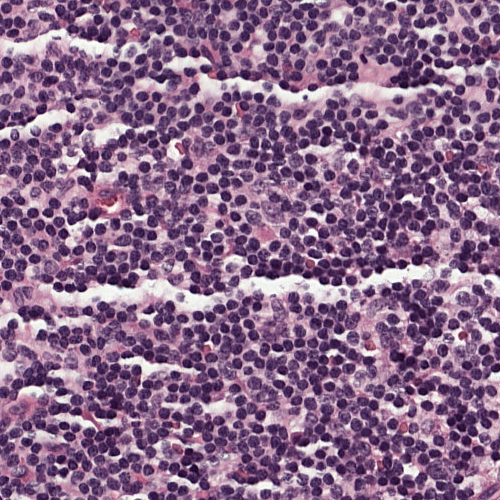

In [96]:
sample_patch = Image.fromarray(patches_all[0][25])
sample_patch

### Positive patch sample:
patch_2122_20487_75383.jpeg

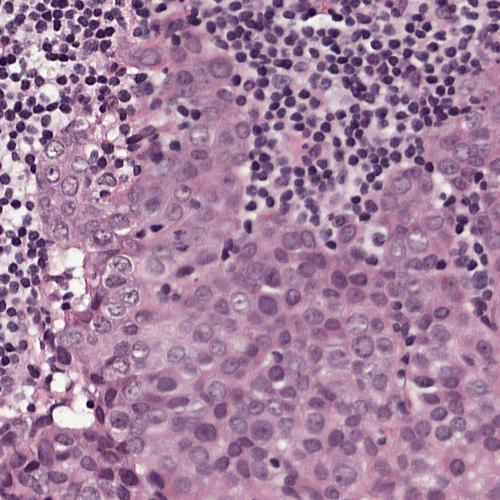

In [56]:
dir_prefix='./dataset_patches/' 
dir_end='/level1/patches/'

pospatch_sample = Image.open(dir_prefix + slide_ + '/level1/12/patches/' + 
                             'patch_2122_20487_75383.jpeg')
pospatch_sample

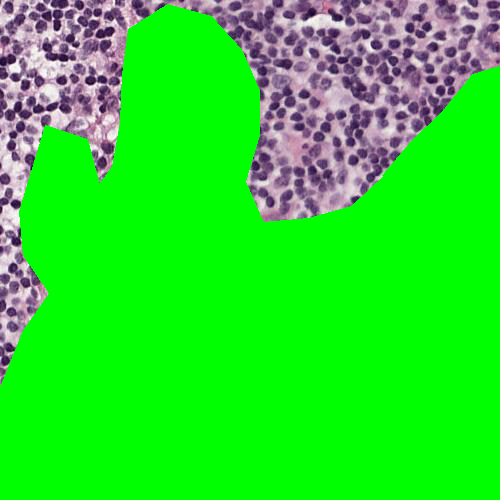

In [100]:
delta_x = 20487
delta_y = 75383

local_anno = list()

for area_ in anno_list:
    tmp = list()
    for coords in area_:
        
        x_ = coords[0] - delta_x
        y_ = coords[1] - delta_y
        
        tmp.append((x_, y_))
    local_anno.append(tmp)
    
local_anno_arr = list()
for contour in local_anno:
    
    arr = np.array(contour)
    arr = np.expand_dims(arr, axis=1)
    local_anno_arr.append(np.array(arr))
    
sample_arr = np.array(pospatch_sample) 
sample_filled=cv2.drawContours(sample_arr, local_anno_arr, -1, 
                                  (PIXEL_BLACK, PIXEL_WHITE, PIXEL_BLACK, PIXEL_WHITE),thickness=-1)
sample_arr = np.array(pospatch_sample) 
sample_annotated=cv2.drawContours(sample_arr, local_anno_arr, -1, 
                                  (PIXEL_BLACK, PIXEL_WHITE, PIXEL_BLACK, PIXEL_WHITE),thickness=3)
Image.fromarray(sample_filled)

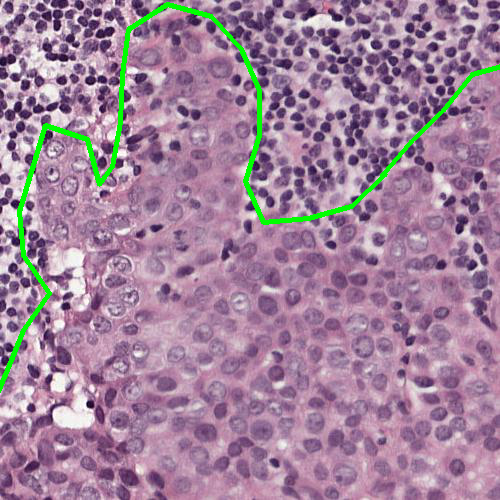

In [101]:
Image.fromarray(sample_annotated)